In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

In [2]:
one_hot_image = np.load("/home/kevinteng/Desktop/npy/fullSess04/sim_one_fullSess04/one_hot/one_last_DG13_3-8-17_preprocessed_dF_fullSess04.npy")
sim_scores = np.load("/home/kevinteng/Desktop/npy/fullSess04/sim_one_fullSess04/sim_last/sim_last_DG13_3-8-17_preprocessed_dF_fullSess04.npy")
session = np.load("/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy")

In [3]:
batch_list = []
for batch in range(len(one_hot_image)):
    coord_list = []
    for n in range(len(one_hot_image[0])):
        one_im = np.squeeze(one_hot_image[batch,n])
        coords = np.array(np.where(one_im==np.max(one_im)))
        coords = coords.reshape((2))
        coord_list.append(coords)
    batch_list.append(np.array(coord_list))

In [4]:
one_hot_coords = np.array(batch_list)/99 #normalize

In [5]:
one_hot_coords.shape

(94, 100, 2)

In [6]:
sim_scores.shape

(752, 100)

In [7]:
#index where there are coordinates at the border for first one_hot_coords
inps_coords = one_hot_coords[0]
idx_boarder = np.array(np.where((inps_coords==1.0) ^ (inps_coords==0.0))).T

In [8]:
x_coords = inps_coords[:,0]

In [9]:
idx_x_coords = np.argsort(x_coords)

In [10]:
print(idx_x_coords)

[49 48 59 60 62 36 35 71 74 78 52 21 81 14 26  1 12 25 94 57  5 64 41 13
 98 87 10 63 33 56 89 15 30 67 93  7  9 27 90 50 76 83 22 32 18 16 46 97
 84 69 40 24 80 70 99 77  2 47 79 44 66 61 65 42 28 19 85 45 11 92 88 86
 55 51  4  0 75 58 17 20 34  6 38 96 73  8  3 72 95 43 54 37 91 29 68 23
 31 53 82 39]


In [11]:
#compute latent space
latent_space = tf.convert_to_tensor(np.concatenate((inps_coords, sim_scores[0][:,np.newaxis]), axis=-1)) 
latent_space = latent_space[tf.newaxis,:,:,tf.newaxis]
latent_space = tf.cast(latent_space, tf.float32)

In [12]:
latent_sort = np.squeeze(latent_space)
print(latent_sort.shape)

(100, 3)


In [13]:
latent_sort_list = []
for idx in idx_x_coords:
    latent_sort_list.append(latent_sort[idx])
    
latent_sort_arr = tf.convert_to_tensor(np.array(latent_sort_list))

(-0.5, 99.5, 99.5, -0.5)

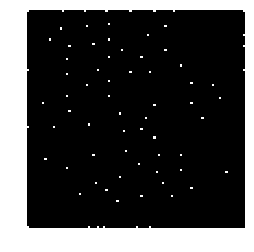

In [14]:
one_hot_im = np.sum(np.squeeze(one_hot_image[0]), axis = 0)
one_hot_im = np.where(one_hot_im>0.9,1.,0.)
plt.imshow(one_hot_im, cmap = 'gray')
plt.axis('off')

In [15]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax, Dropout
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers    

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

In [16]:
n_neurons = 100
#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format('fullSess04'))

In [17]:
reconstuction = decoder_model(latent_space)

# Input Image

(-0.5, 99.5, 99.5, -0.5)

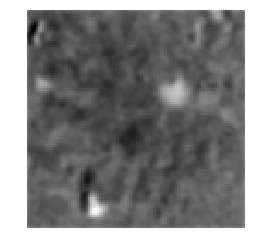

In [18]:
#input image
re_list = utils.resize(session, 100)
re_list = utils.min_max_norm(re_list)

plt.imshow(tf.squeeze(re_list[0]), cmap = 'gray')
plt.axis('off')

# Reconstructed Image

(-0.5, 99.5, 99.5, -0.5)

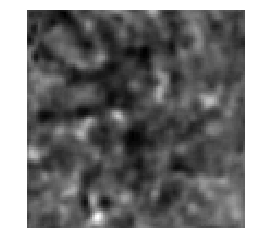

In [19]:
#original latent space
plt.imshow(tf.squeeze(reconstuction), cmap = 'gray')
plt.axis('off')

# Ranked Reconstructed Image

(-0.5, 99.5, 99.5, -0.5)

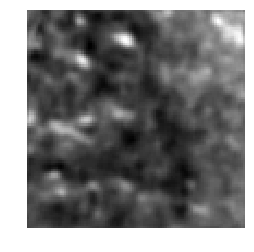

In [36]:
#ranking original coordinates 
latent_00 = decoder_model(latent_sort_arr[np.newaxis,:,:,np.newaxis])
case00 = tf.cast(latent_00, tf.float32)

plt.imshow(tf.squeeze(case00), cmap = 'gray')
plt.axis('off')

# Remove head and tails for 25 

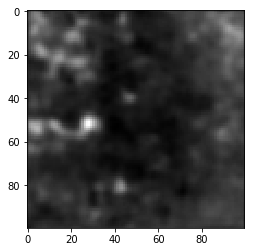

In [21]:
#remove head and tail 25
latent_01 = latent_sort_arr[25:75]
padding = np.zeros((25,3))
latent_01 = np.concatenate((latent_01, padding), axis=0)
latent_01 = np.concatenate((padding, latent_01), axis=0)
latent_01 = tf.cast(latent_01, tf.float32)

case01 = decoder_model(latent_01[np.newaxis,:,:,np.newaxis])
plt.imshow(tf.squeeze(case01), cmap = 'gray')

# Remove top 50 coordinates 

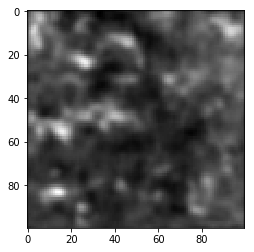

In [22]:
#remove head 50
latent_02 = latent_sort_arr[50:]
padding = np.zeros((50,3))
latent_02 = np.concatenate((padding, latent_02))
latent_02 = tf.cast(latent_02, tf.float32)

case02 = decoder_model(latent_02[np.newaxis,:,:,np.newaxis])
plt.imshow(tf.squeeze(case02), cmap = 'gray')

# Remove bottom 50 coordinates

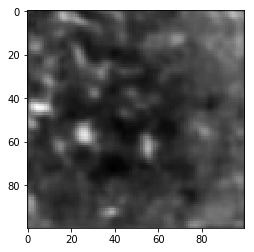

In [23]:
#remove tail 50
latent_03 = latent_sort_arr[:50]
padding = np.zeros((50,3))
latent_03 = np.concatenate((latent_03, padding))
latent_03 = tf.cast(latent_03, tf.float32)

case03 = decoder_model(latent_03[np.newaxis,:,:,np.newaxis])
plt.imshow(tf.squeeze(case03), cmap = 'gray')

# Remove Middle 50

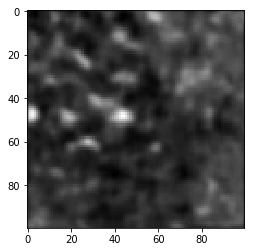

In [24]:
#remove middle 50
latent_04top = latent_sort_arr[:25]
latent_04bottom = latent_sort_arr[75:]
padding = np.zeros((50,3))
latent_04 = np.concatenate((latent_04top, padding))
latent_04 = np.concatenate((latent_04, latent_04bottom))
latent_04 = tf.cast(latent_04, tf.float32)

case04 = decoder_model(latent_04[np.newaxis,:,:,np.newaxis])
plt.imshow(tf.squeeze(case04), cmap = 'gray')

# Randomly Remove 50 coordinates

In [25]:
#randomly remove 50 
rand_ind = np.random.randint(100, size = 50)
padding = np.zeros(3)
latent_05 = np.array(latent_sort_arr)
for idx in rand_ind:
    latent_05[idx] = [0,0,0]

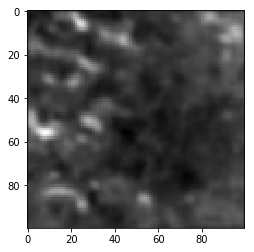

In [27]:
latent_05 = tf.convert_to_tensor(latent_05, tf.float32)

case05 = decoder_model(latent_05[np.newaxis,:,:,np.newaxis])
plt.imshow(tf.squeeze(case05), cmap = 'gray')

---

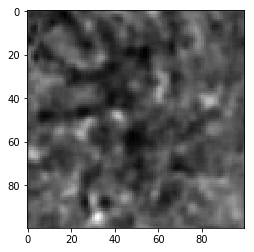

MSE:  0.013871114


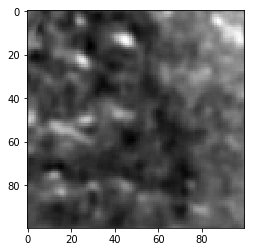

MSE:  0.025048416


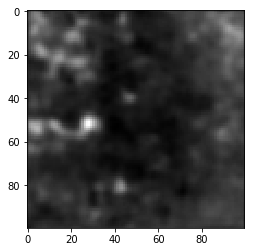

MSE:  0.036419015


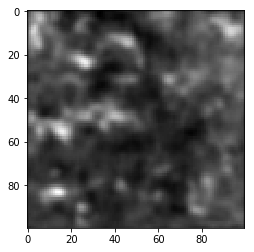

MSE:  0.03433591


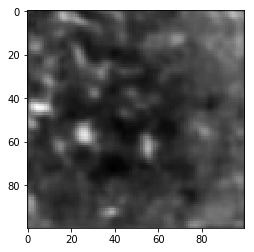

MSE:  0.025748773


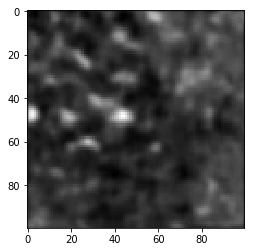

MSE:  0.026408548


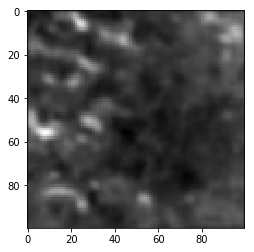

MSE:  0.03219516


In [37]:
#calculating MSE
mse = tf.keras.losses.MeanSquaredError()

latent_rep = [reconstuction, case00 , case01, case02, case03, case04, case05]

for latents in latent_rep:
    plt.imshow(tf.squeeze(latents), cmap = 'gray')
    plt.show()
    mse_out = mse(re_list[0], latents)
    print("MSE: ", mse_out.numpy())
    